In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Tampilkan semua kolom (agar tidak di-truncate)
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

df = pd.read_csv('Training Data.csv', sep=',')
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


# Data Cleansing

## Handle Missing Value

In [3]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 252000 non-null  int64 
 1   income             252000 non-null  int64 
 2   age                252000 non-null  int64 
 3   experience         252000 non-null  int64 
 4   married/single     252000 non-null  object
 5   house_ownership    252000 non-null  object
 6   car_ownership      252000 non-null  object
 7   profession         252000 non-null  object
 8   city               252000 non-null  object
 9   state              252000 non-null  object
 10  current_job_yrs    252000 non-null  int64 
 11  current_house_yrs  252000 non-null  int64 
 12  risk_flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [4]:
df.isnull().sum()\
    .to_frame('missing value')\
    .style.map(lambda val : 'background-color: red' if val > 0 else '' )

,missing value
id,0
income,0
age,0
experience,0
married/single,0
house_ownership,0
car_ownership,0
profession,0
city,0
state,0


Dari data diatas tidak ada missing values

## Handle Duplicated Data

In [5]:
df.duplicated().sum()

0

Dari data diatas tidak ada Duplicated Data

## Handle Outliers

In [6]:
df.describe()

,id,income,age,experience,current_job_yrs,current_house_yrs,risk_flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


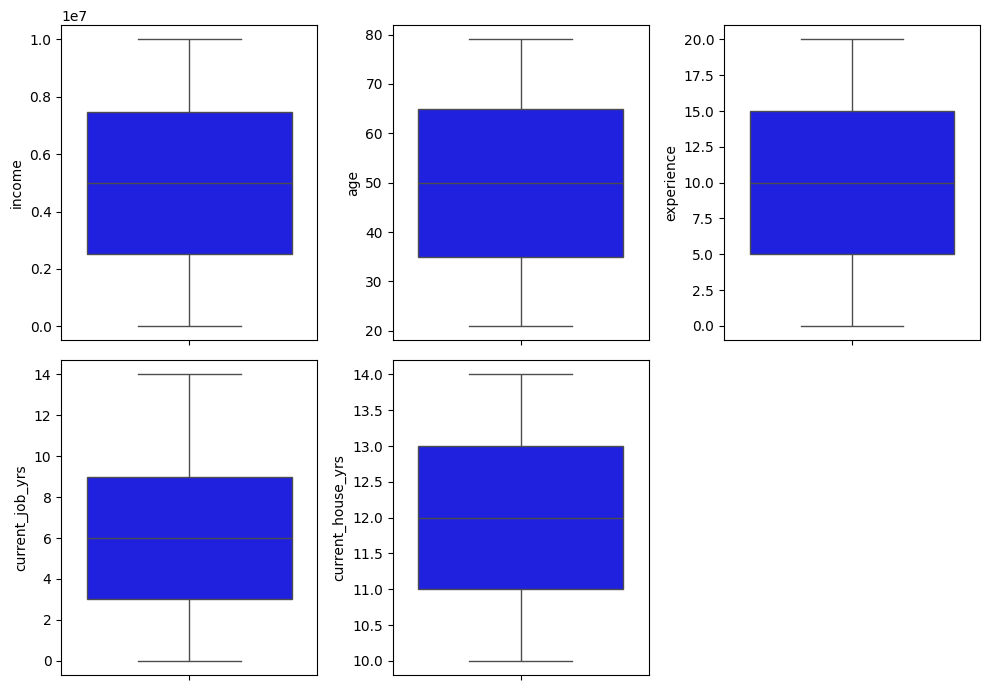

In [7]:
# Analis Boxplot
nums = ['income', 'age', 'experience', 'current_job_yrs','current_house_yrs']

plt.figure(figsize=(10,7))

for i in range(0, len(nums)):
  plt.subplot(2,3, i+1)
  sns.boxplot(df[nums[i]], orient='v', color='blue')
  plt.tight_layout()

plt.show()

Berdasarkan tabel `desribe`, kolom income menunjukkan adanya outlier akan tetapi jika divisualisasi kan tidak adanya indikasi yang menunjukkan outlier. Kolom lain memiliki kemungkinan adanya outlier lebih kecil.

## **Feature Extraction**

Membuat fitur baru dari berupa kategori risk_ratio berdasarkan city

In [8]:
# Agregasi city berdasarkan risk_flag ratio

df_city_agg = df.groupby('city', as_index = False).agg({'id':'count',
                                                        'risk_flag': lambda x: (x==1).sum()})
# Mengganti Nama Kolom
df_city_agg.columns = ['city', 'total_customer', 'risk_flag']

# Menghitung Ratio
df_city_agg['risk_ratio'] = df_city_agg['risk_flag']/df_city_agg['total_customer']

df_city_agg.sort_values(by='risk_ratio', ascending=False)

,city,total_customer,risk_flag,risk_ratio
54,Bhubaneswar,607,198,0.326194
112,Gwalior,616,168,0.272727
41,Bettiah[33],457,122,0.266958
160,Kochi,961,243,0.252862
240,Raiganj,718,172,0.239554
...,...,...,...,...
30,Bangalore,727,27,0.037139
59,Bijapur,572,20,0.034965
282,Sultan_Pur_Majra,528,18,0.034091
78,Dehradun,873,23,0.026346


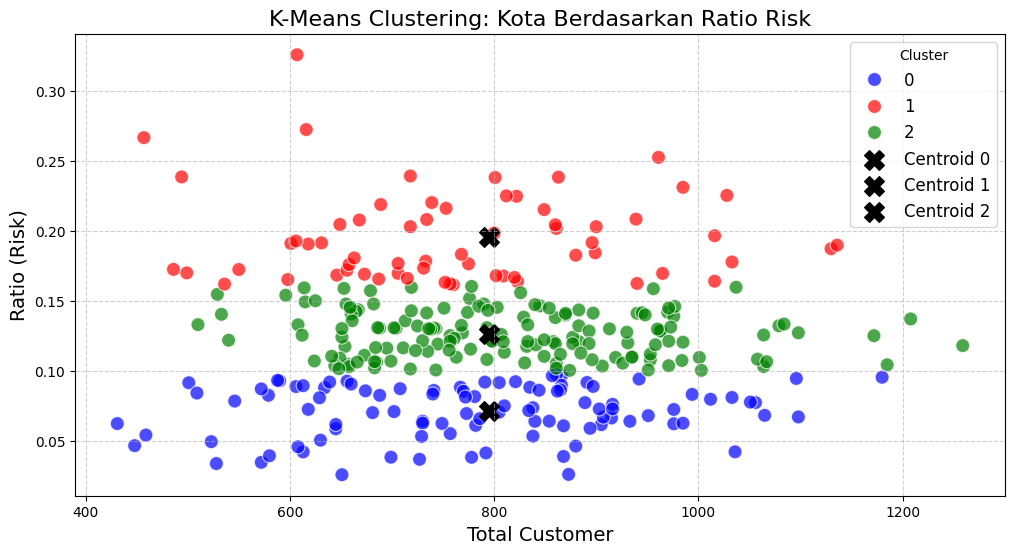

In [9]:
# Mengkategorikan risk_ratio menggunakan K-Means clusterring

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat model KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # Tambahkan n_init=10 untuk menghilangkan warning
df_city_agg['cluster'] = kmeans.fit_predict(df_city_agg[['risk_ratio']])


# Menyiapkan warna untuk setiap cluster
cluster_colors = {0: 'blue', 1: 'red', 2: 'green'}
df_city_agg['color'] = df_city_agg['cluster'].map(cluster_colors)

# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='total_customer',
    y='risk_ratio',
    hue='cluster',
    palette=cluster_colors,
    data=df_city_agg,
    s=100,
    alpha=0.7
)

# Menandai pusat cluster
centroids = kmeans.cluster_centers_
for i, c in enumerate(centroids):
    plt.scatter(
        x=df_city_agg['total_customer'].mean(),
        y=c[0],
        color='black',
        marker='X',
        s=200,
        label=f'Centroid {i}'
    )

# Labeling dan tata letak
plt.title("K-Means Clustering: Kota Berdasarkan Ratio Risk", fontsize=16)
plt.xlabel("Total Customer", fontsize=14)
plt.ylabel("Ratio (Risk)", fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [10]:
# Membuat kolom city category berdasarkan hasil dari K-Means clustering

df_city_agg['city_category'] = df_city_agg['cluster'].map({0: 'Low Risk', 1: 'High Risk', 2: 'Medium Risk'})

df_city_agg.sort_values(by='risk_ratio', ascending=False)


,city,total_customer,risk_flag,risk_ratio,cluster,color,city_category
54,Bhubaneswar,607,198,0.326194,1,red,High Risk
112,Gwalior,616,168,0.272727,1,red,High Risk
41,Bettiah[33],457,122,0.266958,1,red,High Risk
160,Kochi,961,243,0.252862,1,red,High Risk
240,Raiganj,718,172,0.239554,1,red,High Risk
...,...,...,...,...,...,...,...
30,Bangalore,727,27,0.037139,0,blue,Low Risk
59,Bijapur,572,20,0.034965,0,blue,Low Risk
282,Sultan_Pur_Majra,528,18,0.034091,0,blue,Low Risk
78,Dehradun,873,23,0.026346,0,blue,Low Risk


In [11]:
# Gabungkan category df_city_agg dengan df yang kita punya

df = df.merge(df_city_agg[['city','city_category']], on='city', how='left' )

df.head()

,id,income,age,experience,married/single,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,risk_flag,city_category
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,Medium Risk
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,Medium Risk
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,Medium Risk
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,High Risk
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Medium Risk


## Feature Transformation

### Split data


In [12]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['risk_flag','id'])
y = df['risk_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Banyak data latih', X_train.shape[0])
print(f'Banyak data test', X_test.shape[0])

Banyak data latih 201600
Banyak data test 50400


### Encoding Feature Kategorikal


In [13]:
import sklearn
!pip install scikit-learn==1.3.0

In [14]:
# install library target encoder
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.7 MB/s eta 0:00:00


In [15]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

# memilih data yang akan di scale
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Pisahkan kolom berdasarkan kardinalitasnya
fitur_label_encoding = ['married/single', 'house_ownership', 'car_ownership', 'city_category']
fitur_target_encoding = ['profession','city','state']

# Label encoding
le = LabelEncoder()

for i in fitur_label_encoding:
    le.fit(X_train[i])
    X_train_encoded[i] = le.transform(X_train[i])
    X_test_encoded[i] = le.transform(X_test[i])

#Target Encoding
te = TargetEncoder(cols=fitur_target_encoding, smoothing=3)
te.fit(X_train[fitur_target_encoding], y_train)
X_train_te = te.transform(X_train[fitur_target_encoding])
X_test_te = te.transform(X_test[fitur_target_encoding])


# Drop kolom asli karena datanya sudah diencoding
X_train_encoded[fitur_target_encoding] = X_train_te[fitur_target_encoding]
X_test_encoded[fitur_target_encoding]= X_test_te[fitur_target_encoding]

In [16]:
X_train_encoded

,income,age,experience,married/single,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,city_category
200471,9121364,70,18,1,2,0,0.120873,0.236842,0.139313,3,11,0
92611,2636544,39,0,1,2,0,0.128980,0.078621,0.103837,0,11,1
86397,1010539,39,9,1,2,0,0.131487,0.155722,0.128364,4,13,2
110500,3897430,21,2,1,2,0,0.129292,0.192362,0.133547,2,12,0
185133,9470213,41,5,1,0,1,0.107390,0.114327,0.101142,5,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...
119879,2357771,59,1,1,2,1,0.151531,0.220877,0.167524,1,12,0
103694,9314999,51,20,0,2,0,0.131046,0.124021,0.116077,7,10,2
131932,9013930,25,5,1,2,0,0.137370,0.148773,0.139313,5,10,2
146867,6660597,40,2,1,2,1,0.111748,0.096322,0.117185,2,14,2


### Scaling Data

In [17]:
#Menscaling dengan RobustScaler
from sklearn.preprocessing import RobustScaler

feature_to_scale = ['income', 'age', 'experience', 'current_job_yrs', 'current_house_yrs']

ss = RobustScaler()

# memilih data yang akan di scale
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# apply robustscaler pada fitur yang dipilih
X_train_scaled[feature_to_scale] = ss.fit_transform(X_train_encoded[feature_to_scale])
X_test_scaled[feature_to_scale] = ss.transform(X_test_encoded[feature_to_scale])

X_train_scaled.head()

,income,age,experience,married/single,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,city_category
200471,0.824882,0.666667,0.8,1,2,0,0.120873,0.236842,0.139313,-0.500000,-0.5,0
92611,-0.474470,-0.366667,-1.0,1,2,0,0.128980,0.078621,0.103837,-1.000000,-0.5,1
86397,-0.800270,-0.366667,-0.1,1,2,0,0.131487,0.155722,0.128364,-0.333333,0.5,2
110500,-0.221829,-0.966667,-0.8,1,2,0,0.129292,0.192362,0.133547,-0.666667,0.0,0
185133,0.894780,-0.300000,-0.5,1,0,1,0.107390,0.114327,0.101142,-0.166667,0.5,2


### Handle Class Imbalance

In [18]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Misal X_train dan y_train adalah data yang sudah ada
# y_train adalah target

# Menampilkan distribusi awal
print("Distribusi awal:", Counter(y_train))

# Tentukan jumlah yang diinginkan untuk setiap kelas
target_count_0 = 120960
target_count_1 = 80640

# Menyeimbangkan kelas
# 1. Oversampling kelas minoritas (kelas 1) untuk mencapai 80.640
smote = SMOTE(sampling_strategy={1: target_count_1}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 2. Undersampling kelas mayoritas (kelas 0) untuk mencapai 120.960
undersampler = RandomUnderSampler(sampling_strategy={0: target_count_0}, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

# Menampilkan distribusi setelah penyeimbangan
print("Distribusi setelah penyeimbangan:", Counter(y_train_resampled))


Distribusi awal: Counter({0: 176857, 1: 24743})
Distribusi setelah penyeimbangan: Counter({0: 120960, 1: 80640})


### Feature Importance

In [19]:
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train_resampled, y_train_resampled) # fit model decision tree dari data train

DecisionTreeClassifier()

In [20]:
import plotly.express as px

importance = dt.feature_importances_

# Buat DataFrame untuk visualisasi
fitur_penting = pd.DataFrame({
    'Fitur': X_train_resampled.columns,
    'Koefisien': importance
}).sort_values(by='Koefisien', ascending=True)  # Urutkan ascending untuk horizontal bar

# Plot Feature Importance dengan Plotly Express
fig = px.bar(
    fitur_penting,
    x='Koefisien',
    y='Fitur',
    orientation='h',
    text_auto=True
)

# Tambahkan styling ke layout
fig.update_layout(
    width=1200,
    height=600,
    title='<b>Feature Importance</b>',
    xaxis_title='',
    yaxis_title='',
    showlegend=False,
    paper_bgcolor='rgb(255, 255, 255, 1)',
    plot_bgcolor='rgb(255, 255, 255, 0)',
)

# Tampilkan plot
fig.show()

### Feature Selection

In [21]:
from sklearn.ensemble import RandomForestClassifier
# Membuat dan melatih model Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Menampilkan feature importance
feature_importance = model.feature_importances_

# Menyusun dalam DataFrame agar mudah dibaca
importance_df = pd.DataFrame({
    'Fitur': X_train_resampled.columns,
    'Pentingnya': feature_importance
}).sort_values(by='Pentingnya', ascending=False)

print(importance_df)

                Fitur  Pentingnya
7                city    0.159116
0              income    0.153344
6          profession    0.134674
1                 age    0.134231
8               state    0.105520
2          experience    0.099692
9     current_job_yrs    0.089671
10  current_house_yrs    0.059421
11      city_category    0.020349
5       car_ownership    0.018115
4     house_ownership    0.013124
3      married/single    0.012744


In [22]:
from sklearn.feature_selection import VarianceThreshold

# Menampilkan variansi untuk setiap fitur
variances = X_train_encoded.var()
print("Variansi untuk setiap fitur:")
print(variances)

# Proses memilih feature
selector = VarianceThreshold(threshold=0.2)
X_train_cek = selector.fit_transform(X_train_encoded)


# Menampilkan nilai variansi setiap kolom dan fitur yang dipilih
print("\nNilai variansi setiap fitur dan status terpilih:")
for feature, variance, is_selected in zip(variances.index, variances.values, selector.get_support()):
    status = "Pilih" if is_selected else "Dibuang"
    print(f"Fitur: {feature}, Variansi: {variance:.4f}, Status: {status}")

Variansi untuk setiap fitur:
income               8.298498e+12
age                  2.916090e+02
experience           3.600980e+01
married/single       9.192716e-02
house_ownership      1.533933e-01
car_ownership        2.106885e-01
profession           2.825622e-04
city                 2.209429e-03
state                3.011433e-04
current_job_yrs      1.329554e+01
current_house_yrs    1.956611e+00
city_category        6.005995e-01
dtype: float64

Nilai variansi setiap fitur dan status terpilih:
Fitur: income, Variansi: 8298498383591.2383, Status: Pilih
Fitur: age, Variansi: 291.6090, Status: Pilih
Fitur: experience, Variansi: 36.0098, Status: Pilih
Fitur: married/single, Variansi: 0.0919, Status: Dibuang
Fitur: house_ownership, Variansi: 0.1534, Status: Dibuang
Fitur: car_ownership, Variansi: 0.2107, Status: Pilih
Fitur: profession, Variansi: 0.0003, Status: Dibuang
Fitur: city, Variansi: 0.0022, Status: Dibuang
Fitur: state, Variansi: 0.0003, Status: Dibuang
Fitur: current_job_yrs, 

In [26]:
# Memilih Fitur yang digunakan final
X_train_selected = X_train_resampled.drop(['state'], axis=1)
X_test_selected = X_test_scaled.drop(['state'], axis=1)

X_test_selected.head()

,income,age,experience,married/single,house_ownership,car_ownership,profession,city,current_job_yrs,current_house_yrs,city_category
75255,-0.148985,-0.100000,0.8,1,2,0,0.110555,0.109848,0.166667,0.5,2
192435,0.706260,-0.200000,-0.8,1,2,0,0.128980,0.168981,-0.666667,-1.0,2
154839,0.569871,0.166667,-0.1,1,2,0,0.145655,0.134940,0.500000,0.5,2
59774,0.698676,0.366667,1.0,1,2,0,0.123692,0.173664,0.333333,-0.5,0
63788,-0.694731,0.933333,0.3,1,2,0,0.107390,0.122625,0.500000,0.0,2
